<a href="https://colab.research.google.com/github/JunHyeong-data/ML-DL-Study/blob/main/Basic-Deep-Learning/24_faster_r_cnn_%EB%8C%80%EC%B6%A9%EC%95%8C%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

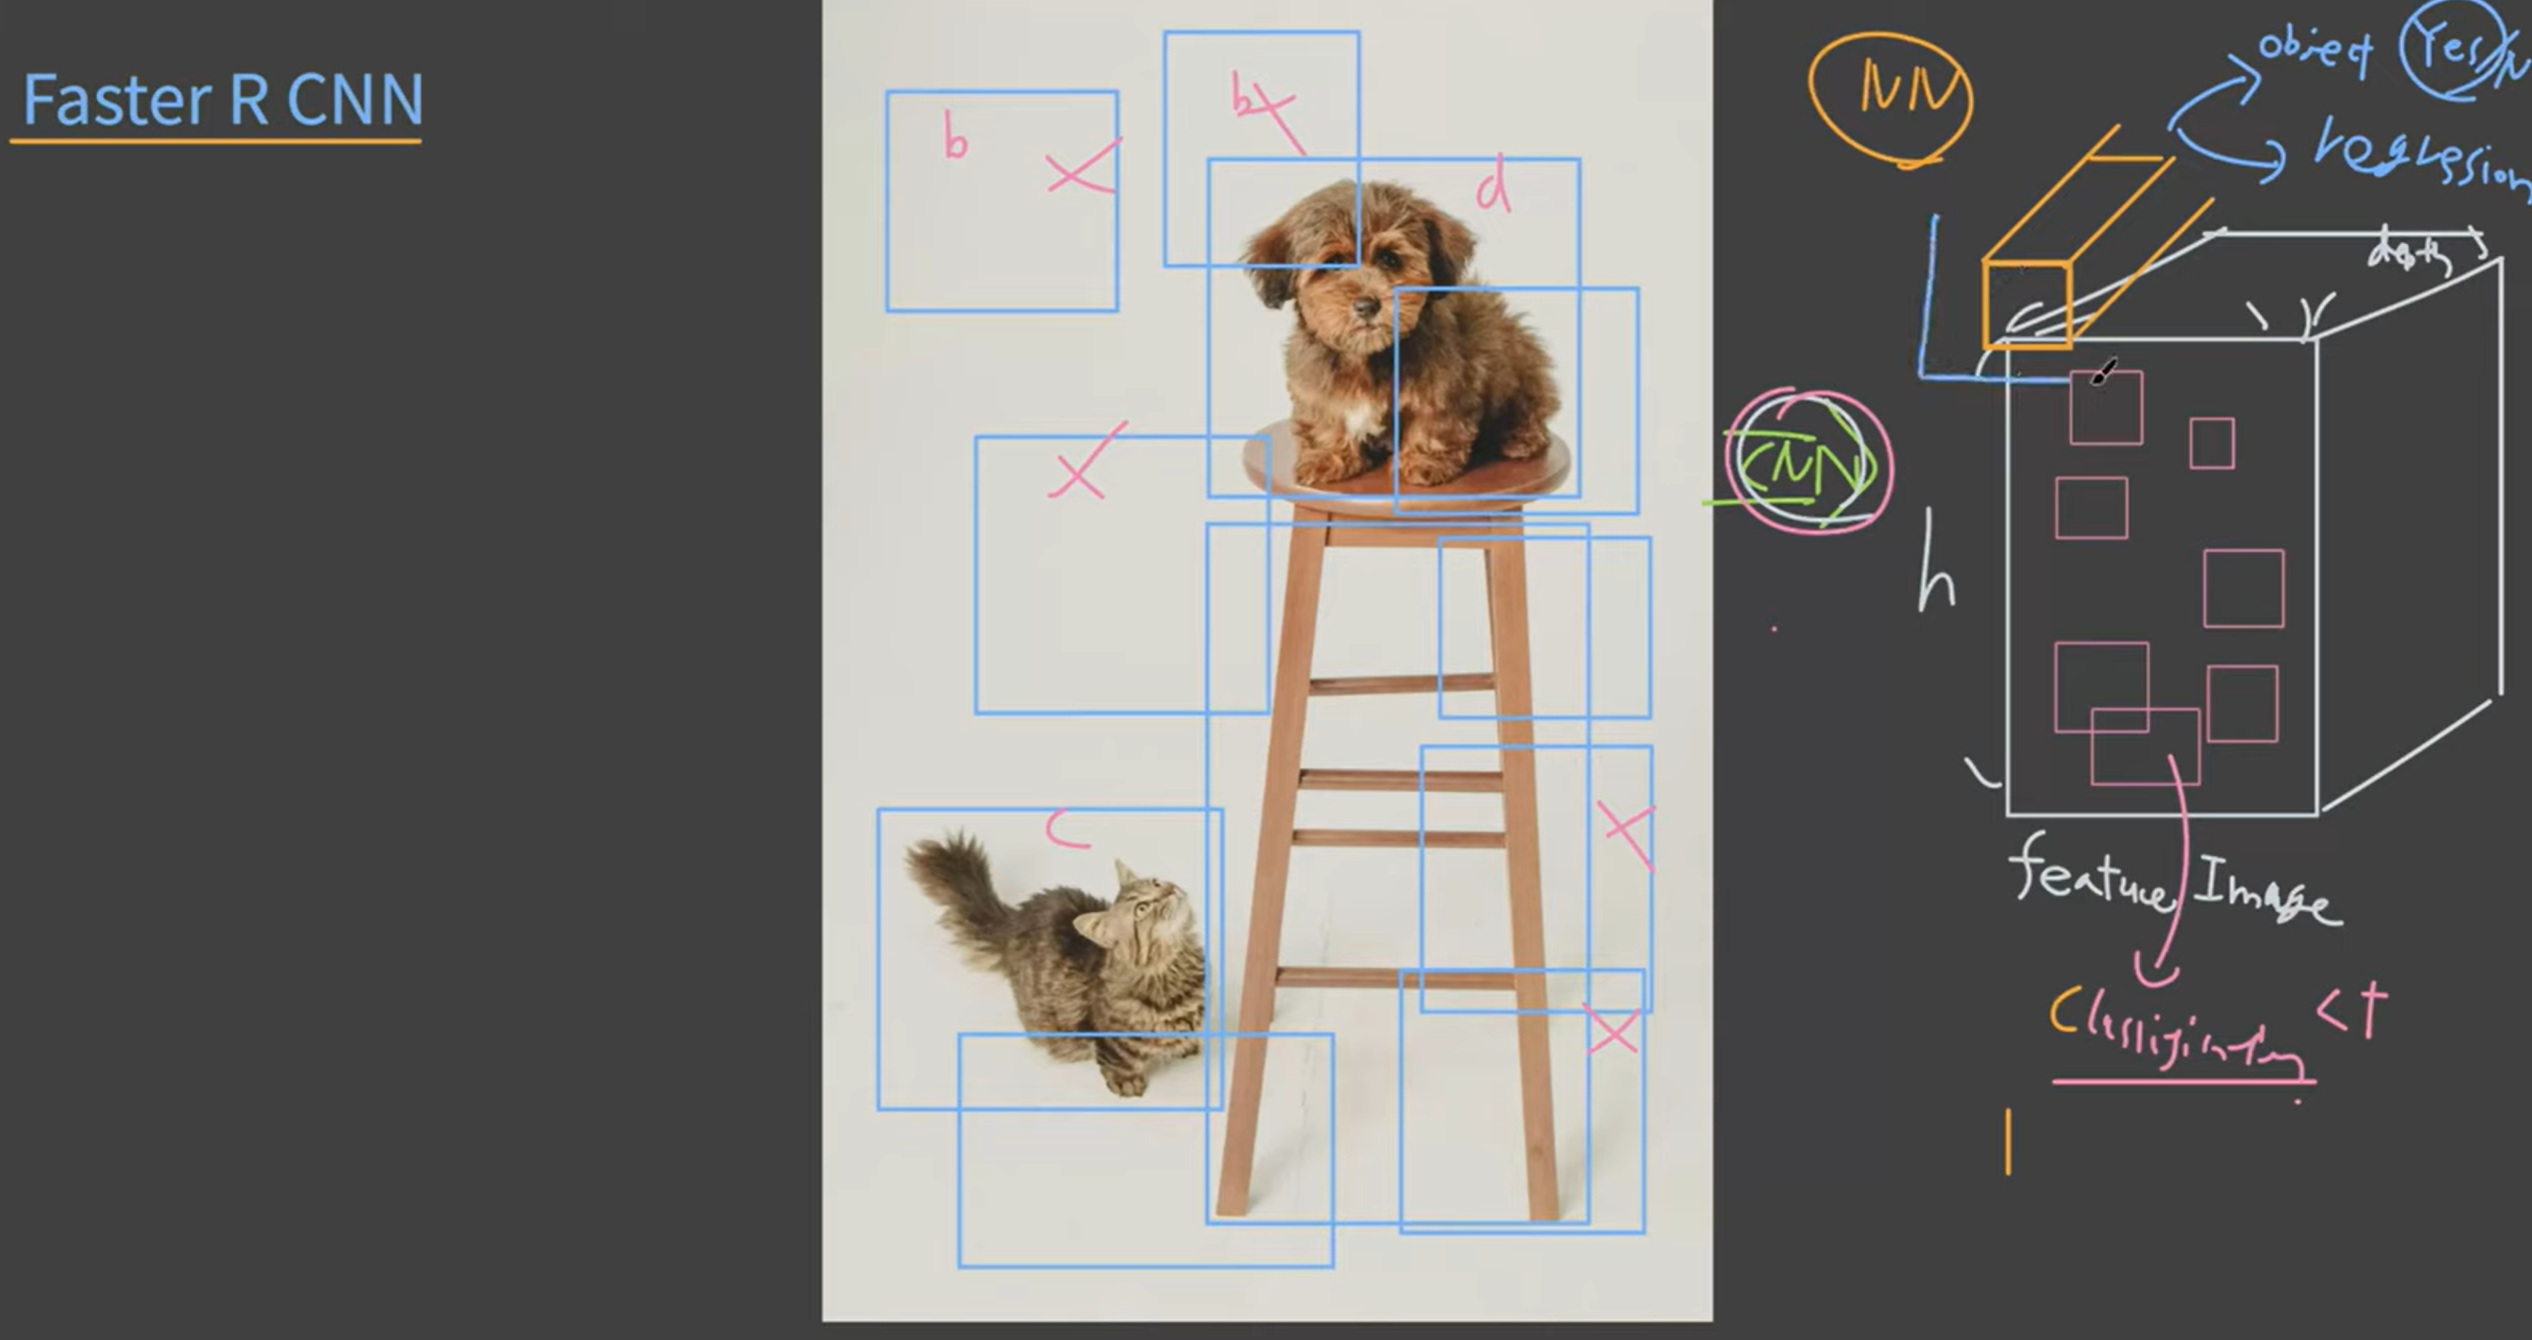

# Faster RCNN 소개

## Faster RCNN 개요
이번 시간에는 오브젝트 디텍션 모델의 조상이라고 할 수 있는 **Faster RCNN**에 대해 알아봅니다.  

- 뉴럴 네트워크 기반 오브젝트 디텍션 모델 예시:  
  - Faster RCNN, Single Shot Detection, YOLO, RetinaNet, Transformer 기반 모델 (DINO, Segment Anything 등)  
- Transformer 이전 모델 중 교양으로 알아두면 좋은 모델: **Faster RCNN**  
- 이해를 위해 **이전 모델들(RCNN, Fast RCNN, Slow RCNN)**부터 살펴봄  

---

## Slow RCNN
- RCNN: Region Proposal을 먼저 생성하고, 후보 영역마다 뉴럴 네트워크를 돌리는 구조
- 이미지 예시:
  - 약 2,000개의 리전 후보(region proposal) 생성  
  - 각 후보를 **리사이즈 후 CNN**에 넣어 Classification 수행  
  - Background는 제거하고, 스코어가 높은 객체만 선택  

### 단점
- 이미지 하나를 분류하는데 0.1초 필요 → 2,000개 후보는 약 200초  
- 매우 느림

---

## Fast RCNN
- Slow RCNN 문제 해결: **전체 이미지에 CNN 한 번만 적용**
- 특징(feature) 추출 후 ROI Pooling으로 후보 영역 매핑
- 후보 영역마다 Classification 수행
- 연산 시간 대폭 감소
- Region Proposal은 기존 클래시컬 알고리즘 사용

---

## Feature Map과 ROI Pooling
- CNN 적용 후 생성된 Feature Map:
  - 공간 정보 유지
  - 채널 Depth: 64~128 등
- ROI Pooling:
  - 후보 영역(region proposal)을 Feature Map에 맵핑
  - 영역별 Classification 수행
- 결과: 전체 이미지 CNN 한 번만 적용 → 속도 향상

---

## Faster RCNN
- Fast RCNN 기반 개선:
  - Region Proposal을 **뉴럴 네트워크(RPN, Region Proposal Network)**로 대체  
- RPN:
  - Sliding window 기반으로 Feature Map에서 관심 있는 객체 후보 생성
  - Binary Classification: Object 있음/없음  
  - Regression: 위치 및 크기 조정
- Anchor Box:
  - 다양한 크기와 비율 체크  
  - 예: 조금 큰 영역, 가로로 긴 객체 등

- 최종 단계:
  - 관심 영역에 Classification  
  - Bounding Box regression으로 위치 세밀하게 보정

---

## Faster RCNN 정리
- Faster RCNN은 전체 이미지에 CNN 적용 → RPN으로 후보 영역 생성 → Classification & Regression 수행
- 일부 복잡한 수식, 자세한 구조는 생략
- Faster RCNN 이해 → YOLO, SSD 같은 고전 모델 이해 용이

---

## 모델 사용 및 트레이닝
- Faster RCNN 포함 대부분 Object Detection 모델:
  - 직접 학습 및 트레이닝 어려움  
  - Fine-tuning도 쉽지 않음  
- 추천:
  - 오픈소스 프로젝트 활용
  - Fine-tuning 정도만 학습
- 다음 시간:
  - Object Detection 필수 개념: **Intersection over Union(IoU), Non-Maximal Suppression(NMS)**  


In [2]:
!git clone https://github.com/NoCodeProgram/deepLearning.git

Cloning into 'deepLearning'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 318 (delta 80), reused 134 (delta 55), pack-reused 139 (from 1)
Receiving objects: 100% (318/318), 17.60 MiB | 25.24 MiB/s, done.
Resolving deltas: 100% (116/116), done.


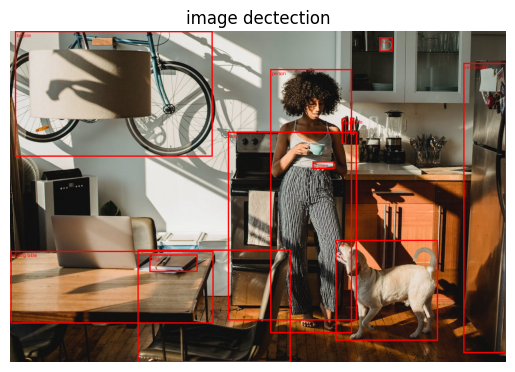

In [5]:
import torch
from torchvision.io import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from PIL import ImageFont
import matplotlib.pyplot as plt

# 1️⃣ 이미지 불러오기
img_path = "deepLearning/detectSegment/sample.jpeg"
img = read_image(img_path)  # shape: [C,H,W], dtype: uint8

# 2️⃣ 모델과 가중치 불러오기
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()  # 평가 모드로 설정

# 3️⃣ 이미지 전처리
preprocess = weights.transforms()
batch = [preprocess(img)]

# 4️⃣ 추론
with torch.no_grad():
    prediction = model(batch)[0]

# 5️⃣ 숫자 label → 이름으로 변환
labels = [weights.meta['categories'][i] for i in prediction['labels']]

# 6️⃣ 폰트 지정 (label이 안 보이는 문제 해결)
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", size=20)
except:
    font = None  # 폰트 못 불러오면 기본값 사용

# 7️⃣ Bounding Box + label 그리기
boxed_img = draw_bounding_boxes(
    img,
    boxes=prediction["boxes"],
    labels=labels,
    colors="red",
    width=3,
    font=font
)

# 8️⃣ PIL 이미지로 변환 후 출력
im = to_pil_image(boxed_img.detach())
plt.imshow(im)
plt.axis('off')
plt.title('image dectection')
plt.show()
